In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np
import collections
import re
import random
import math

In [2]:
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_path = Path(r'../data/fra-eng/fra.txt')
    with open(data_path.as_posix(), 'r', encoding='utf-8') as f:
        return f.read()

In [3]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)

In [5]:
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [6]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [7]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [12]:
# 绘制图表，观察文本序列的词元数量
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.show()

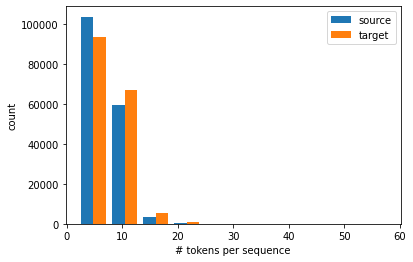

In [13]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', source, target);

In [14]:
# 词表
src_vocab = utils.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

# 为了提高计算效率，我们仍然可以通过截断（truncation）和 填充（padding）方式实现一次只处理一个小批量的文本序列。 假设同一个小批量中的每个序列都应该具有相同的长度num_steps， 那么如果文本序列的词元数目少于num_steps时， 我们将继续在其末尾添加特定的“\<pad\>”词元， 直到其长度达到num_steps； 反之，我们将截断文本序列时，只取其前num_steps 个词元， 并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度， 以便以相同形状的小批量进行加载。

In [15]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [17]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]    # 将每一行转成词表索引
    lines = [l + [vocab['<eos>']] for l in lines]    # 将每一行的词表索引后加入<eos>索引
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])    # 将每一行词表索引截断或填充
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)    # 计算维度1上即每一行词表索引的有效长度
    return array, valid_len

In [18]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = utils.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = utils.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = utils.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [19]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[13, 34,  5,  3,  1,  1,  1,  1],
        [31,  0,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[121,   5,   3,   1,   1,   1,   1,   1],
        [ 77,  23,   0,   4,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([3, 5])
